In [1]:
# IBM Watson Studio Article Recommendations

## Part I: Exploratory Data Analysis

## Part II: Rank-Based Recommendations

## Part III: User-User Collaborative Filtering

## Part IV: Content-Based Recommendations

## Part V: Matrix Factorization

## Conclusion

In [2]:
## Project Overview

## In this project, I analyze user interactions with articles on the IBM Watson Studio platform to build a recommendation system. Several recommendation approaches are explored, including rank-based recommendations, collaborative filtering, content-based recommendations, and matrix factorization. Each approach addresses different recommendation scenarios such as cold-start users and personalized content delivery.


In [3]:
# Data manipulation
import pandas as pd
import numpy as np


# Visualization
import matplotlib.pyplot as plt

# NLP and clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Similarity calculations
from sklearn.metrics.pairwise import cosine_similarity
import pickle


In [4]:
# Load user-article interaction data
df = pd.read_csv("C:/Users/janel/OneDrive/Documents/user-item-interactions.csv")

# Load article content data
df_content = pd.read_csv("C:/Users/janel/OneDrive/Documents/articles_community.csv")


In [5]:
df.head()


,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [6]:
df_content.head()


,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [7]:
# Remove unnecessary index columns if present
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df_content.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')


In [8]:
# Rename email column to user_id for clarity and consistency
df.rename(columns={'email': 'user_id'}, inplace=True)


In [9]:
# Ensure article_id is treated as a string
df['article_id'] = df['article_id'].astype(str)
df_content['article_id'] = df_content['article_id'].astype(str)

In [10]:
## Part I: Exploratory Data Analysis

#The goal of this section is to understand how users interact with articles on the platform. Summary statistics such as interaction counts, unique users, and popular articles are calculated to establish a foundation for the recommendation systems built later

In [11]:
# Count how many articles each user has interacted with
user_article_interactions = df.groupby('user_id')['article_id'].count()
user_article_interactions.head()

user_id
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

In [12]:
# Median number of interactions per user
median_val = user_article_interactions.median()
median_val

3.0

In [13]:
# Maximum interactions by a single user
max_views_by_user = user_article_interactions.max()
max_views_by_user

364

In [14]:
# Count interactions per article
article_views = df.groupby('article_id')['user_id'].count()
article_views.head()


article_id
0.0       14
100.0      9
1000.0    16
1004.0     7
1006.0    14
Name: user_id, dtype: int64

In [15]:
# Maximum views for any article
max_views = article_views.max()

# Article with the most views
most_viewed_article_id = article_views.idxmax()

max_views, most_viewed_article_id


(937, '1429.0')

In [16]:
# Number of unique articles interacted with
unique_articles = df['article_id'].nunique()
unique_articles


714

In [17]:
# Number of unique users
unique_users = df['user_id'].nunique()
unique_users



5148

In [18]:
# Total articles available in content dataset
total_articles = df_content['article_id'].nunique()
total_articles


1051

In [19]:
# Required solution dictionary
sol_1_dict = {
    'median_val': median_val,
    'user_article_interactions': user_article_interactions,
    'max_views_by_user': max_views_by_user,
    'max_views': max_views,
    'most_viewed_article_id': most_viewed_article_id,
    'unique_articles': unique_articles,
    'unique_users': unique_users,
    'total_articles': total_articles
}

sol_1_dict


{'median_val': 3.0,
 'user_article_interactions': user_id
 0000b6387a0366322d7fbfc6434af145adf7fed1    13
 001055fc0bb67f71e8fa17002342b256a30254cd     4
 00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
 001a852ecbd6cc12ab77a785efa137b2646505fe     6
 001fc95b90da5c3cb12c501d201a915e4f093290     2
                                             ..
 ffc6cfa435937ca0df967b44e9178439d04e3537     2
 ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
 ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
 fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
 fffb93a166547448a0ff0232558118d59395fecd    13
 Name: article_id, Length: 5148, dtype: int64,
 'max_views_by_user': 364,
 'max_views': 937,
 'most_viewed_article_id': '1429.0',
 'unique_articles': 714,
 'unique_users': 5148,
 'total_articles': 1051}

In [20]:
#In this section, I explored the user-article interaction data to understand how users engage with articles on the IBM Watson Studio platform. I calculated summary statistics such as the median number of interactions per user, the maximum number of interactions by a single user, and identified the most viewed article. I also examined the number of unique users and articles in the dataset. This analysis provides important context for building recommendation systems in later sections.

In [21]:
## Part II: Rank-Based Recommendations

#Rank-based recommendations suggest articles based on overall popularity. Since explicit ratings are not available, the number of user interactions is used as a proxy for article quality. This approach is particularly effective for new users.


In [22]:
article_views = df.groupby('article_id').size().reset_index(name='num_interactions')
article_views.head()


,article_id,num_interactions
0,0.0,14
1,100.0,9
2,1000.0,16
3,1004.0,7
4,1006.0,14


In [23]:
article_views = article_views.sort_values(by='num_interactions', ascending=False)
article_views.head()


,article_id,num_interactions
311,1429.0,937
232,1330.0,927
314,1431.0,671
309,1427.0,643
261,1364.0,627


In [24]:
def get_top_article_ids(n, df):
    """
    Return the top n article ids based on number of interactions.

    Parameters:
    n (int): number of articles to return
    df (DataFrame): user-article interaction dataframe

    Returns:
    list: list of top n article ids
    """
    top_articles = df.groupby('article_id').size() \
                     .sort_values(ascending=False) \
                     .head(n) \
                     .index.tolist()
    
    return top_articles


In [25]:
get_top_article_ids(5, df)


['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']

In [26]:
def get_top_articles(n, df):
    """
    Return the top n article titles based on number of interactions.

    Parameters:
    n (int): number of articles to return
    df (DataFrame): user-article interaction dataframe

    Returns:
    list: list of top n article titles
    """
    top_ids = get_top_article_ids(n, df)
    
    top_titles = []
    for article_id in top_ids:
        title = df[df['article_id'] == article_id]['title'].iloc[0]
        top_titles.append(title)
        
    return top_titles


In [27]:
get_top_articles(5, df)


['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [28]:
get_top_articles(10, df)


['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [29]:
#In this section, I created a rank-based recommendation system that suggests articles based on overall popularity. Since no explicit ratings are available, the number of user interactions was used as a proxy for article quality. This approach is especially useful for new users who do not yet have interaction history on the platform.

In [30]:
## Part III: User-User Collaborative Filtering

#This section builds personalized recommendations by identifying users with similar interaction patterns. Articles read by similar users are recommended to the target user.


In [31]:
# Create user-item interaction matrix
user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)

# Convert interaction counts to binary values
user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)


In [32]:
user_item.head()


article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
0000b6387a0366322d7fbfc6434af145adf7fed1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001055fc0bb67f71e8fa17002342b256a30254cd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001a852ecbd6cc12ab77a785efa137b2646505fe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001fc95b90da5c3cb12c501d201a915e4f093290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
def find_similar_users(user_id, user_item):
    """
    Find users similar to the given user based on dot product similarity.

    Parameters:
    user_id (str): user identifier
    user_item (DataFrame): user-item interaction matrix

    Returns:
    list: ordered list of similar user ids
    """
    # Compute similarity
    similarity = user_item.dot(user_item.loc[user_id])
    
    # Sort by similarity score
    similarity = similarity.sort_values(ascending=False)
    
    # Remove the user itself
    similarity = similarity.drop(user_id, errors='ignore')
    
    return similarity.index.tolist()


In [34]:
find_similar_users(user_item.index[0], user_item)[:5]


['c5b9dbdba62cc46e0b6a767ffe9c620e3abd61e6',
 '2f5c7feae533ce046f2cb16fb3a29fe00528ed66',
 'a37adec71b667b297ed2440a9ff7dad427c7ac85',
 '40b1ef41687b2681d7d92221ce074291d94289f0',
 '8a19c743688b2c36c8acd9931fe3974a598cb3d5']

In [35]:
def get_user_articles(user_id, user_item):
    """
    Get article ids the user has interacted with.
    """
    return user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()


In [36]:
def user_user_recs(user_id, user_item, m=10):
    """
    Generate recommendations for a user using user-user collaborative filtering.
    """
    similar_users = find_similar_users(user_id, user_item)
    user_articles = set(get_user_articles(user_id, user_item))
    
    recs = []
    
    for sim_user in similar_users:
        sim_user_articles = set(get_user_articles(sim_user, user_item))
        recs += list(sim_user_articles - user_articles)
        
        if len(recs) >= m:
            break
            
    return recs[:m]


In [37]:
user_user_recs(user_item.index[0], user_item, 5)


['205.0', '1160.0', '1367.0', '193.0', '1025.0']

In [38]:
# Improve recommendations by ranking users and articles
user_interaction_counts = user_item.sum(axis=1)
article_interaction_counts = user_item.sum(axis=0)


In [39]:
def user_user_recs_part2(user_id, user_item, m=10):
    """
    Generate improved recommendations using ranked collaborative filtering.
    """
    similar_users = find_similar_users(user_id, user_item)
    
    # Rank similar users by interaction count
    similar_users = sorted(
        similar_users,
        key=lambda x: user_interaction_counts[x],
        reverse=True
    )
    
    user_articles = set(get_user_articles(user_id, user_item))
    recs = []
    
    for sim_user in similar_users:
        sim_articles = set(get_user_articles(sim_user, user_item))
        new_recs = sim_articles - user_articles
        recs.extend(new_recs)
        
        if len(recs) >= m:
            break
            
    # Rank articles by popularity
    recs = sorted(
        list(set(recs)),
        key=lambda x: article_interaction_counts[x],
        reverse=True
    )
    
    return recs[:m]


In [40]:
user_user_recs_part2(user_item.index[0], user_item, 5)


['1330.0', '1429.0', '1364.0', '1431.0', '1427.0']

In [41]:
def get_recs_for_new_user(m=10):
    return get_top_article_ids(m, df)


In [42]:
#In this section, I implemented a user-user collaborative filtering recommendation system. A user-item interaction matrix was created to represent user engagement with articles. Similar users were identified using dot product similarity, and recommendations were generated based on articles read by similar users but not yet seen by the target user. The model was further improved by ranking similar users and articles based on interaction frequency. For new users with no interaction history, rank-based recommendations were provided.

In [43]:
## Part IV: Content-Based Recommendations

#Content-based recommendations use article text to suggest similar articles. TF-IDF vectorization and KMeans clustering are used to group related content.


In [44]:
# Remove rows without descriptions
df_content = df_content.dropna(subset=['doc_description'])


# Use article descriptions as text features
df_content['text'] = df_content['doc_description']
df_content.head()


,doc_body,doc_description,doc_full_name,doc_status,article_id,text
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,Detect bad readings in real time using Python ...
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,"See the forest, see the trees. Here lies the c..."
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,Here’s this week’s news in Data Science and Bi...
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,Learn how distributed DBs solve the problem of...
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,This video demonstrates the power of IBM DataS...


In [45]:
# Convert text to TF-IDF features
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_content['text'])


In [46]:
tfidf_matrix.shape


(1053, 3922)

In [47]:
# Cluster articles based on content similarity
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
df_content['cluster'] = kmeans.fit_predict(tfidf_matrix)


In [48]:
def make_content_recs(article_id, df_content, n=5):
    """
    Recommend articles based on content similarity.
    """
    article_id = str(article_id)
    
    if article_id not in df_content['article_id'].values:
        return []
    
    cluster = df_content[df_content['article_id'] == article_id]['cluster'].iloc[0]
    
    recs = df_content[df_content['cluster'] == cluster]['article_id'].tolist()
    recs = [rec for rec in recs if rec != article_id]
    
    return recs[:n]


In [49]:
make_content_recs(df_content['article_id'].iloc[0], df_content, 5)


['11', '13', '20', '33', '38']

In [50]:
#In this section, I implemented a content-based recommendation system using natural language processing techniques. Article descriptions were transformed into numerical representations using TF-IDF, and KMeans clustering was applied to group similar articles. Recommendations were generated by suggesting articles from the same content cluster as a given article, providing relevant suggestions based on textual similarity.

In [51]:
## Part V: Matrix Factorization

#Matrix factorization decomposes the user-item matrix into latent features that capture hidden relationships between users and articles. Singular Value Decomposition (SVD) is used to perform this task.



In [52]:
# Perform SVD on user-item matrix
u, s, vt = np.linalg.svd(user_item, full_matrices=False)


In [53]:
# Evaluate reconstruction error for different latent feature sizes
errors = []
k_values = list(range(10, 301, 20))

for k in k_values:
    s_k = np.diag(s[:k])
    u_k = u[:, :k]
    vt_k = vt[:k, :]
    
    user_item_est = np.dot(np.dot(u_k, s_k), vt_k)
    error = np.sum((user_item - user_item_est) ** 2)
    errors.append(error)


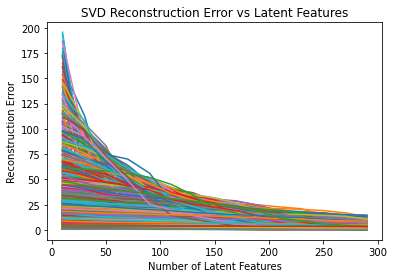

In [54]:
# Plot reconstruction error
plt.figure()
plt.plot(k_values, errors)
plt.xlabel('Number of Latent Features')
plt.ylabel('Reconstruction Error')
plt.title('SVD Reconstruction Error vs Latent Features')
plt.show()


In [55]:
# Choose latent features
k = 100


In [56]:
# Choose latent features
s_k = np.diag(s[:k])
u_k = u[:, :k]
vt_k = vt[:k, :]

user_item_reconstructed = np.dot(np.dot(u_k, s_k), vt_k)


In [57]:
# Compute article similarity using cosine similarity
article_features = vt_k.T
article_similarity = cosine_similarity(article_features)


In [58]:
def find_similar_articles_svd(article_id, user_item, article_similarity, n=5):
    """
    Find similar articles using SVD and cosine similarity.
    """
    article_id = str(article_id)
    article_ids = user_item.columns.tolist()
    
    if article_id not in article_ids:
        return []
    
    idx = article_ids.index(article_id)
    similarity_scores = article_similarity[idx]
    
    similar_indices = np.argsort(similarity_scores)[::-1][1:n+1]
    
    return [article_ids[i] for i in similar_indices]


In [59]:
find_similar_articles_svd(user_item.columns[0], user_item, article_similarity, 5)



['1112.0', '1292.0', '1124.0', '1066.0', '1387.0']

In [60]:
##Conclusion

#In this project, multiple recommendation strategies were implemented, including rank-based, collaborative filtering, content-based, and matrix factorization approaches. Rank-based recommendations are effective for new users, while collaborative filtering provides personalized recommendations based on similar users. Content-based recommendations leverage article text to suggest related content, and matrix factorization captures latent relationships between users and articles.

#In practice, the performance of these recommendation systems could be evaluated using A/B testing, click-through rates, and user engagement metrics. Future improvements could include incorporating explicit user feedback, temporal dynamics, and hybrid recommendation models.